In [30]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from typing import Type
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
#print(wine_quality.metadata) 
  
# variable information 
#print(wine_quality.variables)

print(X.shape) 
print(y.shape)


(6497, 11)
(6497, 1)


In [60]:
X = np.arange(5)
X.T - X

array([0, 0, 0, 0, 0])

In [62]:
class Train():
    def __init__(self, inputs: pd.DataFrame, targets: pd.DataFrame, weights_class: Type[object], train_split: float, k_fold: int, seed: int) -> None:
        self.train_split = train_split
        self.test_split = 1 - train_split
        self.k_fold = k_fold
        self.inputs = inputs
        self.targets = targets
        self.dataset_size = inputs.shape[0]
        self.rng = np.random.default_rng(seed)
        self.weights_class = weights_class

        randomised_inputs = self.rng.permutation(self.inputs.to_numpy())
        randomised_targets = self.rng.permutation(self.targets.to_numpy())
        train_cut = round(self.train_split * self.dataset_size)

        self.train_inputs = randomised_inputs[0:train_cut]
        self.train_targets = randomised_targets[0:train_cut]
        self.test_inputs = randomised_inputs[train_cut:]
        self.test_targets = randomised_targets[train_cut:]

    
    def crossvalidate(self):
        running_loss = 0

        for i in range(self.k_fold):
            train_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold != i]
            test_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold == i]
            weights = self.weights_class.erm(self.train_inputs[train_indices], self.train_targets[train_indices])
            test_loss = self.weights_class.loss(self.train_inputs[test_indices], self.train_targets[test_indices], weights)
            running_loss += test_loss

        return running_loss / self.k_fold
    
    def finaltrain(self):
        weights = self.weights_class.erm(self.train_inputs, self.train_targets)
        test_loss = self.weights_class.loss(self.test_inputs, self.test_targets, weights)
        return test_loss, weights



class LLS():
    def erm(self, inputs, targets):
        print(inputs.shape)
        return np.linalg.inv(inputs.T @ inputs) @ inputs.T @ targets
    
    def loss(self, inputs, targets, weights):
        return (targets - inputs @ weights).T @ (targets - inputs @ weights) / len(inputs)
    

class RIDGELLS():
    def __init__(self, regulariser: float) -> None:
        self.regulariser = regulariser

    def erm(self, inputs, targets):
        return np.linalg.inv(inputs.T @ inputs + self.regulariser * np.identity(inputs.shape[1])) @ inputs.T @ targets
    
    def loss(self, inputs, targets, weights):
        return ((targets - inputs @ weights).T @ (targets - inputs @ weights) + self.regulariser * weights.T @ weights) / len(inputs)
    
class KernelRIDGE():
    def __init__(self, regulariser: float, gamma: float) -> None:
        self.regulariser = regulariser
        self.gamma = gamma

    def erm(self, inputs, targets):
        diff = inputs[:, None, :] - inputs[None, :, :]  
        K = np.exp(- self.gamma * np.sum(diff**2, axis=-1))
        return inputs.T @ np.linalg.inv(K + np.identity(len(K))) @ targets
    
    def loss(self, inputs, targets, weights):
        return ((targets - inputs @ weights).T @ (targets - inputs @ weights) + self.regulariser * weights.T @ weights) / len(inputs)


Simple Linear Regression

In [46]:

wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets
linear_least_squares = LLS()
train_percentage = 0.8
k_folds = 5
seed = 42

Object = Train(X, y, linear_least_squares, train_percentage, k_folds, seed)

loss, _ = Object.finaltrain()
print(loss)


  

(5198, 11)
[[0.73723837]]


Simple Linear Regression with L2 regularisation (Ridge Regression)

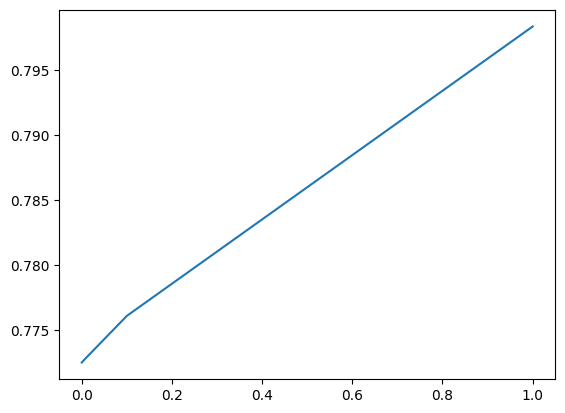

In [44]:
import matplotlib.pyplot as plt

wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets
train_percentage = 0.8
k_folds = 5
seed = 42
regulariser_terms = [0, 0.001, 0.01, 0.1, 1]

cross_val_losses = []
for term in regulariser_terms:
    function_fitter = RIDGELLS(regulariser=term)
    DataHandler = Train(X, y, function_fitter, train_percentage, k_folds, seed)
    x = DataHandler.crossvalidate()
    x = np.squeeze(np.squeeze(x, axis=0), axis=0)
    cross_val_losses.append(x)

plt.plot(regulariser_terms, cross_val_losses)
plt.show()

# Quality of the data is good, expressiveness of the function is bad. Limiting what little expressiveness is available to us is overall a bad thing.
# Suggests increased expressivity is a good direction to go

Kernel Ridge Regression

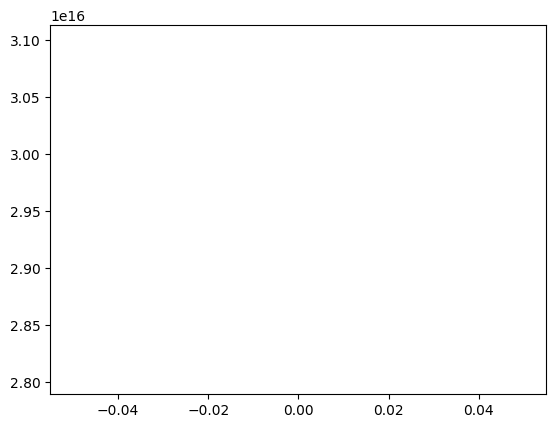

In [65]:
import matplotlib.pyplot as plt

wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets
train_percentage = 0.8
k_folds = 5
seed = 42
regulariser_terms = [0]
gamma_val = 1

cross_val_losses = []
for term in regulariser_terms:
    function_fitter = KernelRIDGE(regulariser=term, gamma=gamma_val)
    DataHandler = Train(X, y, function_fitter, train_percentage, k_folds, seed)
    x = DataHandler.crossvalidate()
    x = np.squeeze(np.squeeze(x, axis=0), axis=0)
    cross_val_losses.append(x)

plt.plot(regulariser_terms, cross_val_losses)
plt.show()


In [ ]:
# Simple Linear Regression
# Ridge Regression
# Kernelised Ridge Regression
# Deep Learning
# Bayesian Deep Learning

Convert from Numpy to Pytorch (Speed Run)

In [72]:
import torch
from typing import Tuple

class Train():
    def __init__(self, inputs: pd.DataFrame, targets: pd.DataFrame, weights_class: Type[object], train_split: float, k_fold: int, seed: int) -> None:
        self.train_split = train_split
        self.test_split = 1 - train_split
        self.k_fold = k_fold
        self.inputs = inputs
        self.targets = targets
        self.dataset_size = inputs.shape[0]
        self.weights_class = weights_class


        torch.manual_seed(seed)
        randomised_inputs = torch.tensor(self.inputs.to_numpy(), dtype=torch.float32)[torch.randperm(self.dataset_size)]
        randomised_targets = torch.tensor(self.targets.to_numpy(), dtype=torch.float32)[torch.randperm(self.dataset_size)]
        train_cut = round(self.train_split * self.dataset_size)

        self.train_inputs = randomised_inputs[0:train_cut]
        self.train_targets = randomised_targets[0:train_cut]
        self.test_inputs = randomised_inputs[train_cut:]
        self.test_targets = randomised_targets[train_cut:]

    
    def crossvalidate(self) -> float:
        running_loss = 0
        for i in range(self.k_fold):
            train_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold != i]
            test_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold == i]
            weights = self.weights_class.erm(self.train_inputs[train_indices], self.train_targets[train_indices])
            test_loss = self.weights_class.loss(self.train_inputs[test_indices], self.train_targets[test_indices], weights)
            running_loss += test_loss

        return running_loss / self.k_fold
    
    def finaltrain(self) -> Tuple[float, torch.Tensor]:
        weights = self.weights_class.erm(self.train_inputs, self.train_targets)
        test_loss = self.weights_class.loss(self.test_inputs, self.test_targets, weights)
        return test_loss, weights



class LLS():
    def erm(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        print(inputs.shape)
        return torch.linalg.inv(inputs.T @ inputs) @ inputs.T @ targets
    
    def loss(self, inputs, targets, weights) -> torch.Tensor:
        return (targets - inputs @ weights).T @ (targets - inputs @ weights) / len(inputs)
    

class RIDGELLS():
    def __init__(self, regulariser: float) -> None:
        self.regulariser = regulariser

    def erm(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return torch.linalg.inv(inputs.T @ inputs + self.regulariser * np.identity(inputs.shape[1])) @ inputs.T @ targets
    
    def loss(self, inputs, targets, weights) -> torch.Tensor:
        return ((targets - inputs @ weights).T @ (targets - inputs @ weights) + self.regulariser * weights.T @ weights) / len(inputs)
    
class KernelRIDGE():
    def __init__(self, regulariser: float, gamma: float) -> None:
        self.regulariser = regulariser
        self.gamma = gamma

    def erm(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        diff = inputs[:, None, :] - inputs[None, :, :]  
        K = np.exp(- self.gamma * np.sum(diff**2, axis=-1))
        return inputs.T @ torch.linalg.inv(K + np.identity(len(K))) @ targets
    
    def loss(self, inputs: torch.Tensor, targets: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
        return ((targets - inputs @ weights).T @ (targets - inputs @ weights) + self.regulariser * weights.T @ weights) / len(inputs)

Deep Learning

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from typing import Type, Tuple

class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(11, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        prediction = self.net(x)
        return prediction

class Train():
    def __init__(self, inputs: pd.DataFrame, targets: pd.DataFrame, net_class: Type[object], loss_fn, train_split: float, lr: float, k_fold: int, batch_size: int, epochs: int, seed: int) -> None:
        self.train_split = train_split
        self.test_split = 1 - train_split
        self.k_fold = k_fold
        self.loss_fn = loss_fn
        self.inputs = inputs
        self.targets = targets
        self.dataset_size = inputs.shape[0]
        self.net_class = net_class
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr

        torch.manual_seed(seed)
        randomised_inputs = torch.tensor(self.inputs.to_numpy(), dtype=torch.float32)[torch.randperm(self.dataset_size)]
        randomised_targets = torch.tensor(self.targets.to_numpy(), dtype=torch.float32)[torch.randperm(self.dataset_size)]
        train_cut = round(self.train_split * self.dataset_size)

        self.train_inputs = randomised_inputs[0:train_cut]
        self.train_targets = randomised_targets[0:train_cut]
        self.test_inputs = randomised_inputs[train_cut:]
        self.test_targets = randomised_targets[train_cut:]

    def optimise(self, inputs, targets, epochs):
        trainset = TensorDataset(inputs, targets)
        trainloader = DataLoader(trainset, batch_size=self.batch_size, shuffle=False)
        optimiser = optim.Adam(self.net_class.parameters(), lr=0.01)

        for _ in range(epochs):
            for X_batch, y_batch in trainloader:
                outputs = self.net_class.forward(X_batch)
                loss = self.loss_fn(outputs, y_batch)
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()
        
        return 'Training Done!'
    
    def evaluate(self, inputs, targets):
        return self.loss_fn(torch.round(self.net_class.forward(inputs)), targets)
    
    def crossvalidate(self) -> float:
        running_loss = 0
        for i in range(self.k_fold):
            train_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold != i]
            test_indices = [j for j in range(len(self.train_inputs)) if j % self.k_fold == i]
            if self.loss_fn is None:
                weights = self.net_class.erm(self.train_inputs[train_indices], self.train_targets[train_indices])
                test_loss = self.net_class.loss(self.train_inputs[test_indices], self.train_targets[test_indices], weights)
            else:
                _ = self.optimise(self.train_inputs[train_indices], self.train_targets[train_indices], self.epochs)
                test_loss = self.evaluate(self.train_inputs[test_indices], self.train_targets[test_indices])
            running_loss += test_loss

        return running_loss / self.k_fold
    
    def finaltrain(self) -> Tuple[float, torch.Tensor]:
        if self.loss_fn is None:
            weights = self.net_class.erm(self.train_inputs, self.train_targets)
            test_loss = self.net_class.loss(self.test_inputs, self.test_targets, weights)
        else:
            _ = self.optimise(self.train_inputs, self.train_targets, self.epochs)
            test_loss = self.evaluate(self.test_inputs, self.test_targets)

        return test_loss

    

In [32]:
import matplotlib.pyplot as plt

wine_quality = fetch_ucirepo(id=186) 
X = wine_quality.data.features 
y = wine_quality.data.targets
train_percentage = 0.8
k_folds = 5
seed = 42
net_object = NeuralNet()
loss_fn = nn.MSELoss()
batch_size = 32
epochs = 50
lrs = [0.01]

cross_val_losses = []
for lr in lrs:
    Object = Train(X, y, net_object, loss_fn, train_percentage, lr, k_folds, batch_size, epochs, seed)
    cross_val_losses.append(Object.crossvalidate())

print(cross_val_losses)

[tensor(0.7986, grad_fn=<DivBackward0>)]


In [19]:
print(cross_val_losses)

[tensor(0.7695, grad_fn=<DivBackward0>), tensor(0.7693, grad_fn=<DivBackward0>), tensor(0.7693, grad_fn=<DivBackward0>)]
